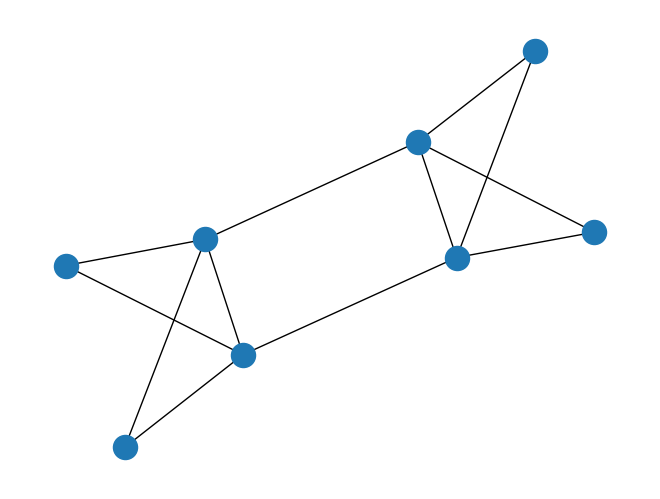

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils


height = 2
width = 2
hidden_dim = 8


n_inputs = 2
n_outputs = 2

def build_edges(n_inputs: int, n_outputs: int, height: int, width: int):
    """
    Builds edges like 2d_grid_graph
    """
    #hidden neurons
    edge_list = list(nx.grid_2d_graph(height, width).edges())
    node_list = list(nx.grid_2d_graph(height, width).nodes())

    #replace each element of edge_list with its index in node_list
    for i in range(len(edge_list)):
        edge_list[i] = (node_list.index(edge_list[i][0]), node_list.index(edge_list[i][1]))
        
    edges = torch.tensor(edge_list)
    
    #input neurons
    input_edges = torch.tensor([
        [
            [x, (height*width) + y] for x in range(width)
        ] for y in range(n_inputs)
    ]).view(-1, 2)

    #output neurons
    output_edges = torch.tensor([
        [
            [(height*width)-(x+1), (height*width) + y+n_inputs] for x in range(width)
        ] for y in range(n_outputs)
    ]).view(-1, 2)

    #merge edges and input_edges
    edges = torch.cat((edges, input_edges, output_edges), dim=0).transpose(0,1)
    return edges



edges = build_edges(n_inputs, n_outputs, height, width)
edges =  torch.stack((torch.concat((edges[0], edges[1]), 0), torch.concat((edges[1], edges[0]), 0)), 0)

n_nodes = height*width + n_inputs + n_outputs

type_dict = {"hidden": [1, 0, 0], "input": [0, 1, 0], "output": [0, 0, 1]}
total_hidden_dim = hidden_dim + len(type_dict["hidden"]) #hidden data + type

# def set_node_state(input_data: torch.Tensor, output_data: torch.Tensor):
x = torch.zeros(n_nodes, total_hidden_dim)

n_hidden_nodes = height*width
x[:n_hidden_nodes] = torch.concat((torch.ones(hidden_dim)*(-1), torch.tensor(type_dict["hidden"])))
x[n_hidden_nodes:n_hidden_nodes+n_inputs] = torch.concat((torch.ones(hidden_dim)*(-1), torch.tensor(type_dict["input"])))
x[n_hidden_nodes+n_inputs:n_hidden_nodes+n_inputs+n_outputs] = torch.concat((torch.ones(hidden_dim)*(-1), torch.tensor(type_dict["output"])))



data = Data(edge_index=edges, x=x)

graph = utils.to_networkx(data, to_undirected=True, remove_self_loops = True)
nx.draw(graph)


In [2]:
#Pytorch geometric graph classification
from torch_geometric.nn import GCNConv, Sequential
from torch.nn import ReLU, LeakyReLU


class UpdateRule(torch.nn.Module):
    def __init__(self, initial_dim, width = 4):
        super(UpdateRule, self).__init__()
        torch.manual_seed(12345)

        self.initial = nn.parameter.Parameter(torch.zeros(initial_dim))

        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.input_vectorizer = nn.Linear(n_inputs, total_hidden_dim, bias=True)
        
        # Vectorizes training targets
        self.reverse_output_vectorizer = nn.Linear(n_outputs, hidden_dim)
        
        self.output_vectorizer = nn.Linear(hidden_dim, 1)
        
        self.conv1 = GCNConv(total_hidden_dim, width)
        
        self.n_hidden_rule_layers = 1
        # self.hidden_rule_layers = Sequential('x, edge_index', 
        #                                      [x for i in range(n_hidden_rule_layers) for x in 
        #                                       [(GCNConv(width, width), 'x, edge_index -> x'), LeakyReLU(0.1, True)]])
        self.hidden_rule_layers = GCNConv(width, width)
        
        # self.conv2 = GCNConv(width, width)
        self.conv_out = GCNConv(width, hidden_dim)
        
        self.reset()

    def get_indices(self, x, type: str):
        return torch.argwhere((x[:,hidden_dim:] == torch.tensor(type_dict[type])).all(1)).squeeze(-1)
    
    def forward(self, x, edge_index, input_data):
        x = x.tanh()
        # types = get_type(x.clone(), hidden_dim=hidden_dim)
        skip = x[:, 8:]
        # print(skip)
        
        #vectorize input
        mask = torch.zeros(x.shape)
        mask[(height*width):((height*width)+n_inputs), :hidden_dim] = 1
        # mask[(height*width):((height*width)+n_inputs)] = 1
        x = x+((self.input_vectorizer(input_data)-x) * mask)
        # print(x)
        #each output needs a unique identifier
        
        # input_indices, output_indices, hidden_indices = self.get_indices(x, "input"), self.get_indices(x, "output"), self.get_indices(x, "hidden")
        # identifiers = F.one_hot(torch.arange(0, input_indices.shape[0] + output_indices.shape[0]))
        # identifiers = torch.concat((torch.zeros(hidden_indices.shape[0], identifiers.shape[0]), identifiers), 0)
        # identifiers[0][0] = 1
        # print(identifiers)
        
        # identifiers = F.one_hot(torch.arange(0, n_nodes))
        # identifiers[self.get_indices(x, "hidden")] *= 0
        # identifiers[0] *= 0
        # x = torch.concat((identifiers, x), -1)
        
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        
        for _ in range(self.n_hidden_rule_layers):
            x = self.hidden_rule_layers(x, edge_index)
            x = self.relu(x)
        
        x = self.conv_out(x, edge_index)
        
        # x = x.tanh()
        
        # x = torch.cat([x, types], dim=-1)
        x = torch.cat([x, skip], dim=-1)
        return x
    
    def print_grad(self):
        for idx,i in enumerate([self.input_vectorizer, self.output_vectorizer]):
            print(idx)
            print(i.weight.grad)
            print()
            
        for idx,i in enumerate([self.conv1]):
            print(idx)
            print(i.lin.weight.grad)
            print()
        
        print("hiddens:")
        for i in self.hidden_rule_layers.children():
            try:
                print(i.lin.weight.grad)
                print()
            except:
                pass
    
    def reset_outputs(self, x, output_data):
        """
        Args:
            x: Network state before rule application
            output_data: Training targets
        """
        if self.vectorized_output is None:
            self.vectorized_output = self.reverse_output_vectorizer(output_data)
        
        output_indices = torch.argwhere((x[:,hidden_dim:] == torch.tensor(type_dict["output"])).all(1)).squeeze(-1)
        x[output_indices, :hidden_dim] = self.vectorized_input
        
        return x
    
    def get_output(self, x):
        """
        Returns last n_outputs nodes in x
        Args:
            x: Network state after rule application
        """
        # output_indices = torch.argwhere((x[:,hidden_dim:] == torch.tensor(type_dict["output"])).all(1)).squeeze(-1)
        #return self.output_vectorizer(x[output_indices, :hidden_dim]).sigmoid().squeeze(-1)
        output = self.output_vectorizer(x[:n_outputs, :hidden_dim]).squeeze(-1)
        # if n_outputs == 1:
        #     return output.sigmoid()
        return output.softmax(-1)
        
        
    
    def reset(self):
        self.vectorized_input = None
        self.vectorized_output = None
        
            
# update_rule = UpdateRule(data.x.shape)


In [7]:
%matplotlib notebook
from utils import reset_inputs, get_type, remove_type, get_output
from tqdm.notebook import tqdm
import time

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()


class SelfOrganizeTest(torch.nn.Module):
    """
    If Rule can learn this data, then it can somewhat self organize
    """
    def __init__(self) :
        super().__init__()
        self.data = torch.tensor([[0,1], [1,0]])
        self.target = torch.tensor([[0,1], [1,0]])
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    def __len__(self):
        return len(self.data)

class ANDDataset(torch.utils.data.Dataset):
    def __init__(self):
        # self.data = torch.tensor([[-1,-1], [-1,1], [1,-1], [1,1]])
        # self.target = [-1,1,1,-1]
        self.data = torch.tensor([[0,0], [0,1],[1,0], [1,1]])
        self.target = torch.tensor([[1,0],[1,0],[1,0],[0,1]])
        
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    def __len__(self):
        return len(self.data)
    
    
class XORDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = torch.tensor([[0,0], [0,1],[1,0], [1,1]])
        self.target = torch.tensor([[1,0],[0,1],[0,1],[1,0]])
        
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    def __len__(self):
        return len(self.data)
    
    
class TranslateDataset(torch.utils.data.Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.data = torch.tensor([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
        self.target = torch.tensor([[0,1,0,0], [0,0,1,0], [0,0,0,1], [1,0,0,0]])
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    def __len__(self):
        return len(self.data)

        
dataset_loader = DataLoader(XORDataset(), batch_size=1, shuffle=True)

update_rule = UpdateRule(data.x.shape)
optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.001)

losses = []
n_steps = 10
batch_size = 1
for epoch in range(1000):
    loss = 0
    for _ in range(batch_size):
        update_rule.reset() 
        
        batch_loss = 0
        # x = data.x.float().clone()
        # x[x == -1] = torch.zeros(n_nodes * hidden_dim)
        x = update_rule.initial
        
        edge_index = data.edge_index.long().clone()
        
        for idx, (problem_data_x, problem_data_y) in enumerate(dataset_loader):
            for i in range(n_steps):
                # if idx == len(dataset_loader)-1:
                output_node_data = torch.zeros(problem_data_y.shape)
                # else:
                # output_node_data = problem_data_y
                x = update_rule(x, edge_index, problem_data_x.float())
                
            
            # if idx == len(dataset_loader)-1:
            # print(problem_data_x,network_output)
            network_output = update_rule.get_output(x)
            batch_loss += F.mse_loss(problem_data_y.float().squeeze(0), network_output)
         
        loss += batch_loss
    
    loss /= batch_size
    
    losses.append(loss.item())
        
    loss.backward()  
    # update_rule.print_grad()
    optimizer.step()  
    optimizer.zero_grad()  
    print(f"\r Epoch {epoch * batch_size} | Loss {loss} | Network in: {problem_data_x}| Network out: {network_output} ", end="")
    
    if epoch % (100 // batch_size) == 0:
        # print(x)
        print()

ax.clear()
ax.plot(losses)
fig.canvas.draw()

<IPython.core.display.Javascript object>

 Epoch 0 | Loss 1.0 | Network in: tensor([[0, 0]])| Network out: tensor([0.5000, 0.5000], grad_fn=<SoftmaxBackward0>) 
 Epoch 100 | Loss 0.974934458732605 | Network in: tensor([[0, 1]])| Network out: tensor([0.4821, 0.5179], grad_fn=<SoftmaxBackward0>) 
 Epoch 200 | Loss 0.1447744518518448 | Network in: tensor([[1, 1]])| Network out: tensor([0.7661, 0.2339], grad_fn=<SoftmaxBackward0>)  
 Epoch 275 | Loss 0.0074936929158866405 | Network in: tensor([[0, 1]])| Network out: tensor([0.0440, 0.9560], grad_fn=<SoftmaxBackward0>) 

KeyboardInterrupt: 

In [ ]:
import numpy as np
np.set_printoptions(precision=3)


def run_rule(data_x, update_rule, n_steps = 2):
    x = data.x.float().clone()
    x[x == -1] = torch.zeros(n_nodes * hidden_dim)
    update_rule.reset()
    edge_index = data.edge_index.long().clone()
    for i in range(n_steps):
        x = update_rule(x, edge_index, data_x.float())
    
        network_output = update_rule.get_output(x)
        print(network_output)
    return network_output
    

run_rule(torch.tensor([[0, 1]]), update_rule)